In [3]:
import torch
import pandas as pd

from pathlib import Path
from torchvision.transforms import v2
from sklearn.model_selection import train_test_split


from utils import WildfireDataset, load_data

In [2]:
data_folder = Path('./data/valid')

# Data Exploration

In [14]:
nowildfire_files = [file for file in (data_folder / "nowildfire").iterdir() if file.is_file()]
wildfire_files = [file for file in (data_folder / "wildfire").iterdir() if file.is_file()]

fulldataset = pd.DataFrame([
    {
        "file": file,
        "label": 0
    }
    for file in nowildfire_files
] + [
    {
        "file": file,
        "label": 1
    }
    for file in wildfire_files
])

fulldataset.head()

,file,label
0,"data/valid/nowildfire/-75.660251,45.393888.jpg",0
1,"data/valid/nowildfire/-75.678106,45.416973.jpg",0
2,"data/valid/nowildfire/-73.547162,45.510815.jpg",0
3,"data/valid/nowildfire/-73.772957,45.507158.jpg",0
4,"data/valid/nowildfire/-75.605463,45.40009.jpg",0


In [15]:
train, valid = train_test_split(fulldataset, train_size=0.8, random_state=42, shuffle=True)

In [16]:
transform = v2.Compose([
    v2.ToImage(), # Convert into Image tensor
    v2.ToDtype(torch.float32, scale=True)
])

train_dataset = WildfireDataset(train, transform)
val_dataset = WildfireDataset(valid, transform)

# Clustering

In [10]:
from models import ViTEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from utils import WildfireDataset, load_data
from pathlib import Path
import pandas as pd

In [11]:
encoder = ViTEncoder()

train, val, test = load_data(Path("./data"), True)

Using device: cpu


In [12]:
dataset = WildfireDataset(pd.concat([train, val]))

In [13]:
encoded_images, labels = encoder.encode_images(dataset)

Process images: 100%|██████████| 10/10 [00:01<00:00,  6.98it/s]


In [14]:
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(encoded_images, labels)

In [15]:
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(encoded_images)

predicted_cluster = kmeans.predict(encoded_images)

In [32]:
import numpy as np

cluster2label = []
for cluster in range(n_clusters):
    cluster_labels: np.ndarray = labels[(predicted_cluster==cluster) & (labels!=-1)]
    cluster_labels = cluster_labels.astype(np.int32)
    cluster2label.append({
        "cluster" : cluster,
        "label" : np.argmax(np.bincount(cluster_labels))
    })

In [30]:
cluster2label

[{'cluster': 0, 'label': 0},
 {'cluster': 1, 'label': 0},
 {'cluster': 2, 'label': 0}]

In [36]:
x = reduced_data[:, 0]
y = reduced_data[:, 1]
c = labels

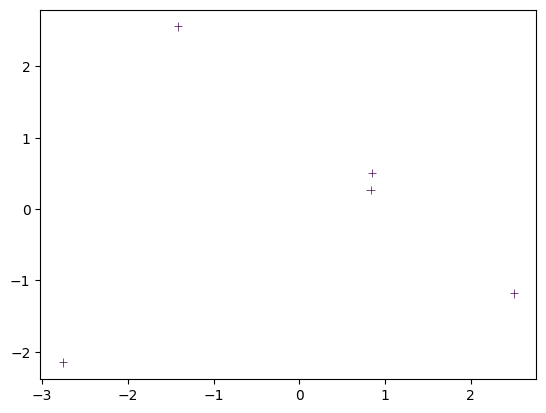

In [34]:
plt.scatter(x, y, c=c, linewidths=0.5, marker="+")
plt.show()